# Explainability with SageMaker Clarify - Partial Dependence Plots (PDP)

## Runtime

This notebook takes approximately 30 minutes to run.

## Contents

1. [Overview](#Overview)
1. [Prerequisites and Data](#Prerequisites-and-Data)
    1. [Initialize SageMaker](#Initialize-SageMaker)
    1. [Download data](#Download-data)
    1. [Loading the data: Adult Dataset](#Loading-the-data:-Adult-Dataset) 
    1. [Data inspection](#Data-inspection) 
    1. [Data encoding and upload to S3](#Encode-and-Upload-the-Dataset) 
1. [Train and Deploy XGBoost Model](#Train-XGBoost-Model)
    1. [Train Model](#Train-Model)
    1. [Deploy Model](#Deploy-Model)
1. [Amazon SageMaker Clarify](#Amazon-SageMaker-Clarify)
    1. [Explaining Predictions with PDP](#Explaining-Predictions-with-PDP)
    1. [Viewing the Explainability Report](#View-the-Explainabiltiy-Report)
1. [Clean Up](#Clean-Up)

## Overview
Amazon SageMaker Clarify provides you the ability to gain insight into your model with Partial Dependency Plots (PDP). PDP shows the marginal effect features have on the predicted outcome of a machine learning model. Intuitively, you can interpret the partial dependence as the target response which is expected as a function of each input feature of interest.

This sample notebook walks you through:  

1. Key terms and concepts needed to understand SageMaker Clarify
1. Generating PDPs
1. Accessing the explainability report and viewing PDPs

In doing so, the notebook first trains a [SageMaker XGBoost](https://docs.aws.amazon.com/sagemaker/latest/dg/xgboost.html) model using a training dataset, then uses SageMaker Clarify to explain the corresponding testing dataset in CSV format with PDP. In addition to CSV, SageMaker Clarify also supports analyzing datasets in [SageMaker JSON Lines dense format](https://docs.aws.amazon.com/sagemaker/latest/dg/cdf-inference.html#common-in-formats). 

This notebook focuses on model explainability with PDP. If you would like to learn more about model explainability with Kernel SHAP, please visit [this notebook](https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-clarify/fairness_and_explainability/fairness_and_explainability.ipynb). You can find the detailed documentation of SageMaker Clarify at [What Is Fairness and Model Explainability for Machine Learning Predictions](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-fairness-and-explainability.html) and more demo notebooks at [aws-sagemaker-examples GitHub repository](https://github.com/aws/amazon-sagemaker-examples/tree/main/sagemaker-clarify).

## Prerequisites and Data
### Initialize SageMaker

In [2]:
from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify-pdp"
region = session.boto_region_name

# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import os
import boto3
from datetime import datetime
import matplotlib.pyplot as plt

role = get_execution_role()
s3_client = boto3.client("s3")

### Download data

Data Source: https://archive.ics.uci.edu/ml/machine-learning-databases/adult/

Let's __download__ the data and save it in the local folder with the name `adult.data` and `adult.test` from UCI repository$^{[1]}$. 

$^{[1]}$Dua Dheeru, and Efi Karra Taniskidou. "[UCI Machine Learning Repository](http://archive.ics.uci.edu/ml)". Irvine, CA: University of California, School of Information and Computer Science (2017).

In [3]:
adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]

if not os.path.isfile("adult.data"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "adult.data"
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "adult.test"
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data already on disk.
adult.test already on disk.


### Loading the data: Adult Dataset
From the UCI repository of machine learning datasets, this database contains 14 features concerning demographic characteristics of 45,222 rows (32,561 for training and 12,661 for testing). The task is to predict whether a person has a yearly income that is more or less than $50,000.

Here are the features and their possible values:

1. **Age**: continuous.
1. **Workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
1. **Fnlwgt**: continuous (the number of people the census takers believe that observation represents).
1. **Education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
1. **Education-num**: continuous.
1. **Marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
1. **Occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
1. **Relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
1. **Ethnic group**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
1. **Sex**: Female, Male.
    * **Note**: this data is extracted from the 1994 Census and enforces a binary option on Sex
1. **Capital-gain**: continuous.
1. **Capital-loss**: continuous.
1. **Hours-per-week**: continuous.
1. **Native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

Next, we specify our binary prediction task:  
15. **Target**: <= 50,000, > $50,000.

In [4]:
training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data inspection

Plotting histograms for the distribution of the different features is a good way to visualize the data. Let's plot a few of the features that can be considered sensitive.
Let's take a look specifically at the Sex feature of a census respondent. In the first plot we see that there are fewer Female respondents as a whole but especially in the positive outcomes, where they form ~$\frac{1}{7}$th of respondents.

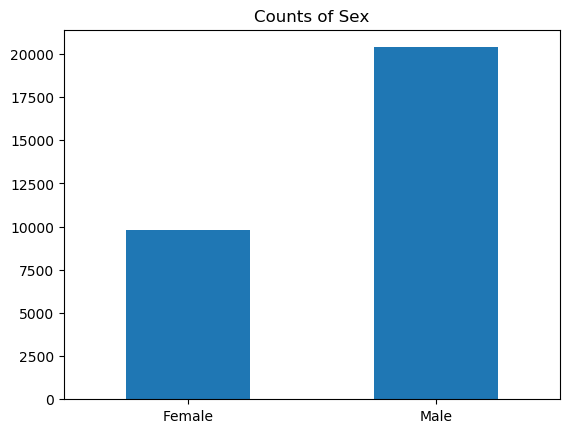

In [5]:
%matplotlib inline
training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)
plt.show()

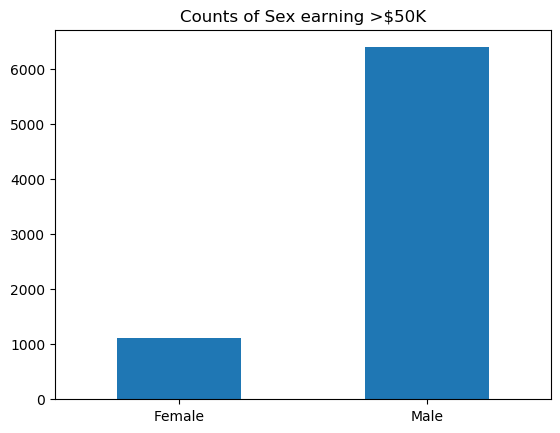

In [6]:
%matplotlib inline
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)
plt.show()

## Encode and Upload the Dataset

Here we encode the training and test data. Encoding input data is not necessary for SageMaker Clarify, but is necessary for the model.

In [7]:
from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
        else:
            result[column] = result[column].astype("float")
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
testing_data.to_csv("test_data.csv", index=False, header=False)

A quick note about our encoding: the "Female" Sex value has been encoded as 0 and "Male" as 1.

In [8]:
training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39.0,5,77516.0,9,13.0,4,0,1,4,1,2174.0,0.0,40.0,38
1,0,50.0,4,83311.0,9,13.0,2,3,0,4,1,0.0,0.0,13.0,38
2,0,38.0,2,215646.0,11,9.0,0,5,1,4,1,0.0,0.0,40.0,38
3,0,53.0,2,234721.0,1,7.0,2,5,0,2,1,0.0,0.0,40.0,38
4,0,28.0,2,338409.0,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4


Lastly, let's upload the data to S3.

In [9]:
from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_data.csv", "s3://{}/{}".format(bucket, prefix))

### Train XGBoost Model
#### Train Model
Since our focus is on understanding how to use SageMaker Clarify, we keep it simple by using a standard XGBoost model.

In [10]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.5-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)

INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2023-02-10-22-46-57-370



2023-02-10 22:46:57 Starting - Starting the training job...
2023-02-10 22:47:13 Starting - Preparing the instances for training........
2023-02-10 22:48:03 Downloading - Downloading input data....
2023-02-10 22:48:28 Training - Downloading the training image...
2023-02-10 22:48:48 Training - Training image download completed. Training in progress.......
2023-02-10 22:49:23 Uploading - Uploading generated training model..
2023-02-10 22:49:34 Completed - Training job completed


#### Deploy Model
Here we create the SageMaker model.

In [11]:
model_name = "DEMO-clarify-xgb-model-{}".format(datetime.now().strftime("%d-%m-%Y-%H-%M-%S"))
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

INFO:sagemaker:Creating model with name: DEMO-clarify-xgb-model-10-02-2023-22-49-39


'DEMO-clarify-xgb-model-10-02-2023-22-49-39'

## Amazon SageMaker Clarify

Now that you have your model set up, let's say hello to SageMaker Clarify!

In [12]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

INFO:sagemaker.image_uris:Defaulting to the only supported framework/algorithm version: 1.0.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


### Explaining Predictions with PDP

PDP shows the marginal effect features have on the predicted outcome of a model. SageMaker Clarify can generate PDPs for a user-specified list of features, or for top k features with largest SHAP values.

#### Writing DataConfig and ModelConfig

A `DataConfig` object communicates some basic information about data I/O to SageMaker Clarify. We specify where to find the input dataset, where to store the output, the target column (`label`), the header names, and the dataset type.



In [13]:
pdp_explainability_output_path = "s3://{}/{}/clarify-explainability-pdp".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=test_uri,
    s3_output_path=pdp_explainability_output_path,
    label="Target",
    headers=testing_data.columns.to_list(),
    dataset_type="text/csv",
)

A `ModelConfig` object communicates information about your trained model. To avoid additional traffic to your production models, SageMaker Clarify sets up and tears down a dedicated endpoint when processing.
* `instance_type` and `instance_count` specify your preferred instance type and instance count used to run your model on during SageMaker Clarify's processing. The testing dataset is small, so a single standard instance is good enough to run this example. If you have a large complex dataset, you may want to use a better instance type to speed up, or add more instances to enable Spark parallelization.
* `accept_type` denotes the endpoint response payload format, and `content_type` denotes the payload format of request to the endpoint.

In [14]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

A `ModelPredictedLabelConfig` provides information on the format of your predictions. XGBoost model outputs probabilities of samples, so SageMaker Clarify invokes the endpoint then uses `probability_threshold` to convert the probability to binary labels for bias analysis. Prediction above the threshold is interpreted as label value `1` and below or equal as label value `0`.

In [15]:
predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

#### Writing PDPConfig

A `PDPConfig` object specifies how the PDP analysis is done. There are 2 ways in which we can plot PDP with SageMaker Clarify based on specified parameters:

* If a list of `features` is specified, PDPs are plotted for each feature in the list.
* If `top_k_features` is specified, feature importance is ranked based on SHAP values and PDPs are plotted for the top k features. If not specified, the default number of features is `10`.

Let's look at the stand alone PDP analysis first. To generate PDP without Kernel SHAP, we need to specify the `features` we want PDP analysis done on as a list of feature headers. We can also specify an optional `grid_resolution` parameter, which indicates the number of evenly spaced buckets a numerical feature is grouped into across its range of values. The feature values used to plot PDP are the midpoints of each bucket. If not specified, the default `grid_resolution` is `20`. For categorical features, each unique feature value is used in the PDP plot.



In [16]:
pdp_config = clarify.PDPConfig(
    features=["Sex", "Age", "Education-Num"],
    grid_resolution=15,
)

Now we can run the analysis with the above inputs. The command in the cell below creates a SageMaker Processing job and may take around 10 minutes to complete. 

In [17]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=pdp_config,
    model_scores=predictions_config,
    logs=False,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'], 'label': 'Target', 'predictor': {'model_name': 'DEMO-clarify-xgb-model-10-02-2023-22-49-39', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'probability_threshold': 0.8, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pdp': {'grid_resolution': 15, 'top_k_features': 10, 'features': ['Sex', 'Age', 'Education-Num']}}}
INFO:sagemaker:Creating processing-job with name Clarify-Explainability-2023-02-10-22-49-40-241


....................................................................................................................!

### View the Explainabiltiy Report

You can access the explainability report in pdf, html and ipynb formats in the following S3 bucket:

In [18]:
pdp_explainability_output_path

's3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-sagemaker-clarify-pdp/clarify-explainability-pdp'

For example, you can also download a copy of the html report and view it in-place here.

In [19]:
!aws s3 cp {pdp_explainability_output_path}/report.html ./explainability-report.html

download: s3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-sagemaker-clarify-pdp/clarify-explainability-pdp/report.html to ./explainability-report.html



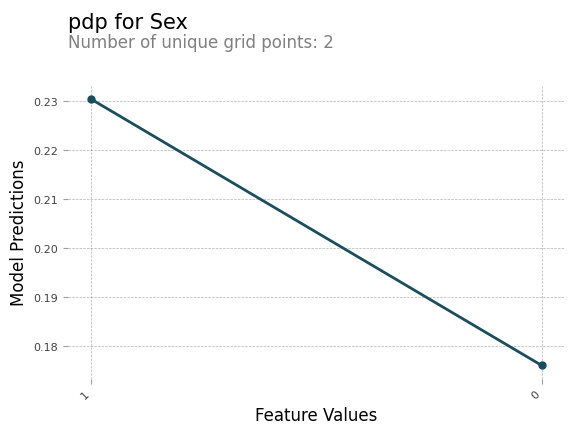
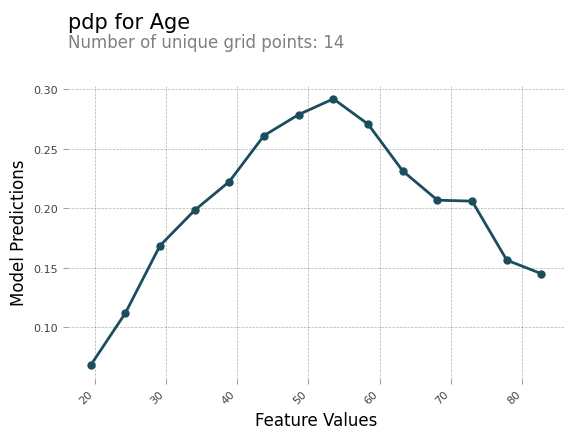
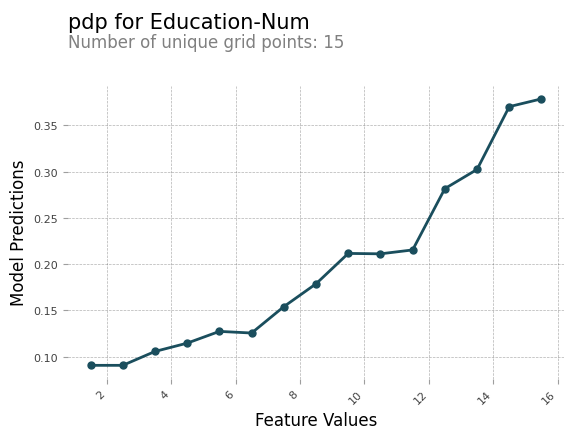

In [20]:
import IPython

IPython.display.HTML(filename="explainability-report.html")

### PDP Analysis with SHAP

 Instead of specifying the features we want to run PDP analysis on, we can use [SHAP values](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-shapley-values.html) to rank feature importance and select the top_k_features to plot PDPs. SHAP value of an input feature indicates the amount of contribution that this feature makes to the model prediction.

In [21]:
pdp_config = clarify.PDPConfig(
    top_k_features=5,
    grid_resolution=25,
)

The `SHAPConfig` object communicates information about required by the Kernel SHAP algorithm to compute SHAP values. 

* A `Baseline` dataset is required by the Kernel SHAP algorithm. If a `baseline` is not provided, it will be automatically computed as the cluster centers of the dataset by SageMaker Clarify using K-means or K-prototypes. Baseline dataset type shall be the same as `dataset_type` of `DataConfig`, and baseline samples shall only include features. By definition, `baseline` should either be a S3 URI to the baseline dataset file, or an in-place list of samples. In this case we chose the latter, and put the first sample of the test dataset to the list. For more information on the baseline dataset, see [SHAP Baselines for Explainability](https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-feature-attribute-shap-baselines.html).
* `num_samples` determines the size of the generated synthetic dataset to compute the SHAP values. If not provided then Clarify job will choose a proper value according to the count of features. 
* `agg_method` specifies how the per-instance feature importance should be aggregated over the dataset to compute the overall (global) feature importance. For more details see [Amazon AI Fairness and Explainability Whitepaper](https://pages.awscloud.com/rs/112-TZM-766/images/Amazon.AI.Fairness.and.Explainability.Whitepaper.pdf).


In [22]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
)

In [23]:
pdp_with_shap_explainability_output_path = "s3://{}/{}/clarify-explainability-pdp-with-shap".format(
    bucket, prefix
)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=test_uri,
    s3_output_path=pdp_with_shap_explainability_output_path,
    label="Target",
    headers=testing_data.columns.to_list(),
    dataset_type="text/csv",
)

Now we can run the analysis with the above inputs. The command in the cell below creates a SageMaker Processing job and may take around 15 minutes to complete.

In [24]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=[pdp_config, shap_config],
    logs=False,
)

INFO:sagemaker.clarify:Analysis Config: {'dataset_type': 'text/csv', 'headers': ['Age', 'Workclass', 'fnlwgt', 'Education', 'Education-Num', 'Marital Status', 'Occupation', 'Relationship', 'Ethnic group', 'Sex', 'Capital Gain', 'Capital Loss', 'Hours per week', 'Country', 'Target'], 'label': 'Target', 'predictor': {'model_name': 'DEMO-clarify-xgb-model-10-02-2023-22-49-39', 'instance_type': 'ml.m5.xlarge', 'initial_instance_count': 1, 'accept_type': 'text/csv', 'content_type': 'text/csv'}, 'methods': {'report': {'name': 'report', 'title': 'Analysis Report'}, 'pdp': {'grid_resolution': 25, 'top_k_features': 5}, 'shap': {'use_logit': False, 'save_local_shap_values': True, 'baseline': [[25.0, 2.0, 226802.0, 1.0, 7.0, 4.0, 6.0, 3.0, 2.0, 1.0, 0.0, 0.0, 40.0, 37.0]], 'num_samples': 15, 'agg_method': 'mean_abs'}}}
INFO:sagemaker:Creating processing-job with name Clarify-Explainability-2023-02-10-22-59-24-674


.....................................................................................................................................................................................................!

Similar to the previous explainability report, you can access the report in pdf, html and ipynb formats in the following S3 bucket: 

In [25]:
pdp_with_shap_explainability_output_path

's3://sagemaker-us-west-2-000000000000/sagemaker/DEMO-sagemaker-clarify-pdp/clarify-explainability-pdp-with-shap'

### Clean Up
Finally, don't forget to clean up the resources we set up and used for this demo!

In [26]:
session.delete_model(model_name)

INFO:sagemaker:Deleting model with name: DEMO-clarify-xgb-model-10-02-2023-22-49-39
